In [5]:
!pip install torch torchvision torchaudio


In [27]:
import os
import torch
import utils
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import torchvision
from torchvision.transforms import v2 as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = masks_to_boxes(masks)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        img = tv_tensors.Image(img)
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    def __len__(self):
        return len(self.imgs)
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes,
    )

    return model

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

model = get_model_instance_segmentation(num_classes=2)

dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0, collate_fn=utils.collate_fn
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    # Train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # Update the learning rate
    lr_scheduler.step()
    # Evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions)

Epoch: [0]  [ 0/60]  eta: 0:08:54  lr: 0.000090  loss: 3.0321 (3.0321)  loss_classifier: 1.2896 (1.2896)  loss_box_reg: 0.1393 (0.1393)  loss_mask: 1.5925 (1.5925)  loss_objectness: 0.0099 (0.0099)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 8.9113  data: 0.0191
Epoch: [0]  [10/60]  eta: 0:07:05  lr: 0.000936  loss: 1.3347 (1.6548)  loss_classifier: 0.4599 (0.5597)  loss_box_reg: 0.2386 (0.2561)  loss_mask: 0.5516 (0.8238)  loss_objectness: 0.0058 (0.0105)  loss_rpn_box_reg: 0.0049 (0.0046)  time: 8.5046  data: 0.0175
Epoch: [0]  [20/60]  eta: 0:05:54  lr: 0.001783  loss: 0.8530 (1.2281)  loss_classifier: 0.2133 (0.3859)  loss_box_reg: 0.2489 (0.2691)  loss_mask: 0.3360 (0.5573)  loss_objectness: 0.0077 (0.0115)  loss_rpn_box_reg: 0.0040 (0.0042)  time: 8.8728  data: 0.0195
Epoch: [0]  [30/60]  eta: 0:04:34  lr: 0.002629  loss: 0.6596 (1.0191)  loss_classifier: 0.0954 (0.2866)  loss_box_reg: 0.2623 (0.2705)  loss_mask: 0.2254 (0.4446)  loss_objectness: 0.0110 (0.0120)  loss_rpn_box_reg: 

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:01:10  model_time: 1.3862 (1.3862)  evaluator_time: 0.0122 (0.0122)  time: 1.4071  data: 0.0083
Test:  [49/50]  eta: 0:00:01  model_time: 1.1154 (1.2334)  evaluator_time: 0.0023 (0.0045)  time: 1.1659  data: 0.0088
Test: Total time: 0:01:02 (1.2475 s / it)
Averaged stats: model_time: 1.1154 (1.2334)  evaluator_time: 0.0023 (0.0045)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.536
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.529
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.557
 Average Re

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:01:33  model_time: 1.8510 (1.8510)  evaluator_time: 0.0070 (0.0070)  time: 1.8658  data: 0.0079
Test:  [49/50]  eta: 0:00:01  model_time: 1.6806 (1.9197)  evaluator_time: 0.0030 (0.0050)  time: 1.8652  data: 0.0121
Test: Total time: 0:01:36 (1.9374 s / it)
Averaged stats: model_time: 1.6806 (1.9197)  evaluator_time: 0.0030 (0.0050)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.665
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.780
 Average Re

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:00:59  model_time: 1.1761 (1.1761)  evaluator_time: 0.0047 (0.0047)  time: 1.1900  data: 0.0090
Test:  [49/50]  eta: 0:00:01  model_time: 1.2042 (1.3010)  evaluator_time: 0.0021 (0.0032)  time: 1.2849  data: 0.0091
Test: Total time: 0:01:05 (1.3140 s / it)
Averaged stats: model_time: 1.2042 (1.3010)  evaluator_time: 0.0021 (0.0032)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.808
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.949
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.753
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.820
 Average Re

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:01:05  model_time: 1.2936 (1.2936)  evaluator_time: 0.0045 (0.0045)  time: 1.3056  data: 0.0074
Test:  [49/50]  eta: 0:00:01  model_time: 1.1610 (1.2448)  evaluator_time: 0.0019 (0.0028)  time: 1.2627  data: 0.0094
Test: Total time: 0:01:02 (1.2573 s / it)
Averaged stats: model_time: 1.1610 (1.2448)  evaluator_time: 0.0019 (0.0028)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.837
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.974
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.853
 Average Re

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:00:56  model_time: 1.1201 (1.1201)  evaluator_time: 0.0044 (0.0044)  time: 1.1312  data: 0.0066
Test:  [49/50]  eta: 0:00:01  model_time: 1.5574 (1.3907)  evaluator_time: 0.0033 (0.0033)  time: 1.6659  data: 0.0110
Test: Total time: 0:01:10 (1.4042 s / it)
Averaged stats: model_time: 1.5574 (1.3907)  evaluator_time: 0.0033 (0.0033)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.841
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.524
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.856
 Average Re

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:02:32  model_time: 3.0137 (3.0137)  evaluator_time: 0.0109 (0.0109)  time: 3.0541  data: 0.0290
Test:  [49/50]  eta: 0:00:01  model_time: 1.5083 (1.8768)  evaluator_time: 0.0030 (0.0049)  time: 1.4725  data: 0.0103
Test: Total time: 0:01:34 (1.8958 s / it)
Averaged stats: model_time: 1.5083 (1.8768)  evaluator_time: 0.0030 (0.0049)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.846
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.751
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.861
 Average Re

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:01:31  model_time: 1.7987 (1.7987)  evaluator_time: 0.0124 (0.0124)  time: 1.8210  data: 0.0095
Test:  [49/50]  eta: 0:00:02  model_time: 1.8663 (2.0488)  evaluator_time: 0.0051 (0.0054)  time: 2.1891  data: 0.0132
Test: Total time: 0:01:43 (2.0688 s / it)
Averaged stats: model_time: 1.8663 (2.0488)  evaluator_time: 0.0051 (0.0054)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.850
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.751
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.864
 Average Re

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:01:30  model_time: 1.7923 (1.7923)  evaluator_time: 0.0075 (0.0075)  time: 1.8069  data: 0.0071
Test:  [49/50]  eta: 0:00:01  model_time: 1.7078 (1.9040)  evaluator_time: 0.0036 (0.0050)  time: 1.8850  data: 0.0120
Test: Total time: 0:01:36 (1.9218 s / it)
Averaged stats: model_time: 1.7078 (1.9040)  evaluator_time: 0.0036 (0.0050)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.851
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.751
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.867
 Average Re

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:01:33  model_time: 1.8583 (1.8583)  evaluator_time: 0.0075 (0.0075)  time: 1.8750  data: 0.0088
Test:  [49/50]  eta: 0:00:05  model_time: 2.0026 (5.5984)  evaluator_time: 0.0037 (0.0056)  time: 11.3414  data: 0.0126
Test: Total time: 0:04:40 (5.6170 s / it)
Averaged stats: model_time: 2.0026 (5.5984)  evaluator_time: 0.0037 (0.0056)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.853
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.368
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.751
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.867
 Average R

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:01:33  model_time: 1.8376 (1.8376)  evaluator_time: 0.0159 (0.0159)  time: 1.8666  data: 0.0112
Test:  [49/50]  eta: 0:00:01  model_time: 1.7828 (1.7646)  evaluator_time: 0.0030 (0.0043)  time: 1.7967  data: 0.0136
Test: Total time: 0:01:29 (1.7821 s / it)
Averaged stats: model_time: 1.7828 (1.7646)  evaluator_time: 0.0030 (0.0043)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.853
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.751
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.867
 Average Re

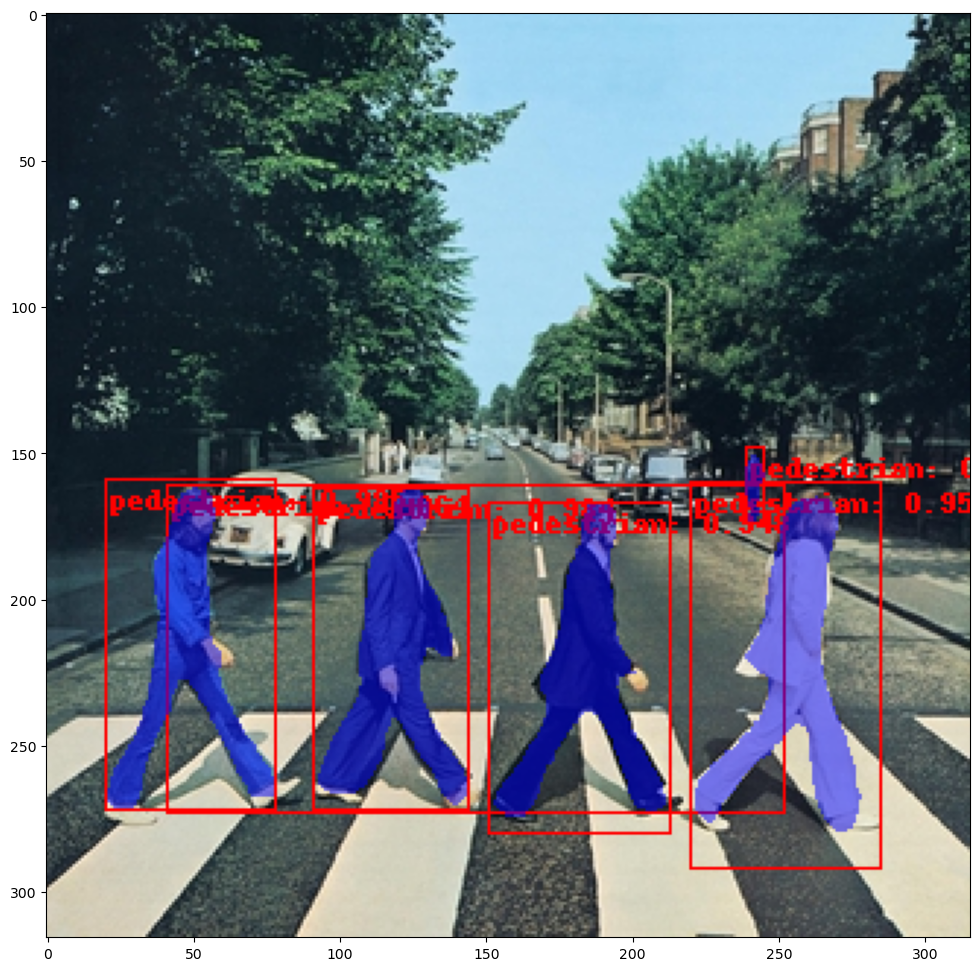

In [28]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("Beatles.jpg")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))